## **LOAN ELIGIBILITY PREDICTION**

---
 ### **Project By: Alaissa Shaikh**



In today's financial landscape, assessing loan applications efficiently and accurately is crucial for both lenders and borrowers. Lenders need to minimize risks while ensuring fair lending practices, while borrowers need access to credit for various purposes. This project aims to develop and evaluate machine learning models to predict loan eligibility based on applicant data.


---


The analysis will utilize a dataset containing information about loan applications, including applicant demographics, financial information, and loan details. Machine learning algorithms such as Logistic Regression, Random Forest, and Support Vector Machines will be employed to build predictive models. The performance of these models will be evaluated using metrics such as accuracy, precision, recall, F1-score, and AUC. Additionally, feature engineering techniques will be explored to potentially improve model performance. The goal of this project is to develop a robust and reliable model that can assist lenders in making informed decisions regarding loan applications.

---



In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, PowerTransformer
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import shap
import warnings
warnings.filterwarnings('ignore')

#### **Loading and understanding dataset**



In [2]:
# Loading Dataset
df = pd.read_csv('/content/loan_data.csv')
print("Dataset Loaded Successfully!")
print(df.head())

Dataset Loaded Successfully!
    Loan_ID Gender Married  ApplicantIncome  LoanAmount Loan_Status
0  LP001002   Male      No             5849         NaN           Y
1  LP001003   Male     Yes             4583       128.0           N
2  LP001005   Male     Yes             3000        66.0           Y
3  LP001006   Male     Yes             2583       120.0           Y
4  LP001008   Male      No             6000       141.0           Y


This dataset appears to be about loan applications, with each row representing an individual applicant.  The dataset includes features such as the applicant's gender, marital status, income, and the amount of the loan requested. It also shows whether the loan application was approved or not. The data  applicants, and they have a range of incomes and loan amounts requested. There is also a column for Loan_ID, which is likely a unique identifier for each loan application.

---



#### **Exploratory Data Analysis**



In [3]:
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
Loan_ID             0
Gender              0
Married             0
ApplicantIncome     0
LoanAmount         21
Loan_Status         0
dtype: int64


The missing values in the LoanAmount column are likely due to a combination of factors, including incomplete applications, data entry errors, and potential issues with the data collection process. By carefully considering these factors and the specific context of the data, you can choose the most appropriate method for handling the missing values.

---



#### **Missing Value Treatment**



In [4]:
for col in df.columns:
    if df[col].dtype == 'object':
        df[col].fillna(df[col].mode()[0], inplace=True)
    else:
        df[col].fillna(df[col].median(), inplace=True)

*  Enable Analysis: Missing values can prevent you from performing certain analyses, such as calculating summary statistics or building machine learning models. Imputation allows you to continue with the analysis without discarding data.


---


*  Improve Model Performance: Many machine learning algorithms cannot handle missing values directly. Imputation helps ensure that the model can learn from the complete data.

---



#### **Outlier Analysis**



In [5]:
df = df[df['ApplicantIncome'] < 25000]
df = df[df['LoanAmount'] < 400000]

*  Threshold Selection: The thresholds of 25000 and 400000 for ApplicantIncome and LoanAmount respectively are chosen somewhat arbitrarily. Determining appropriate thresholds for outlier removal often requires domain expertise and careful analysis of the data distribution.

---


*  Impact of Removal: Removing outliers can impact the representativeness of the data. It's important to understand the potential consequences of removing data points before proceeding.

#### **Feature Engineering**



In [6]:
# Create new features
df['Income_to_Loan_Ratio'] = df['ApplicantIncome'] / df['LoanAmount']
df['Log_ApplicantIncome'] = np.log1p(df['ApplicantIncome'])
df['Log_LoanAmount'] = np.log1p(df['LoanAmount'])

**Creating Income_to_Loan_Ratio:**

*  The values in this new column are calculated by dividing the ApplicantIncome of each row by the corresponding LoanAmount.


*  This ratio can provide valuable information about the applicant's ability to repay the loan.

---


**Creating Log_ApplicantIncome:**

*  It applies the natural logarithm (using np.log1p for numerical stability) to the ApplicantIncome values.


*  Logarithmic transformations can help to normalize data that is skewed or has a wide range of values. This can improve the performance of some machine learning models.


---


**Creating Log_LoanAmount:**

*  It applies the natural logarithm (using np.log1p) to the LoanAmount values.


*  Similar to Log_ApplicantIncome, this transformation can help normalize the LoanAmount data and potentially improve model performance.
Benefits of Feature Engineering:


---


*  Improved Model Performance: New features can capture important relationships between variables that might not be obvious from the original data.


*  Better Interpretability: Some engineered features can make the model's predictions more interpretable.


*  Normalization: Transformations like logarithmic scaling can help normalize data, which is often beneficial for many machine learning algorithms.

---



#### **Label Encoding**



In [7]:
# Label Encoding for categorical variables
le = LabelEncoder()
for col in df.select_dtypes(include='object').columns:
    df[col] = le.fit_transform(df[col])

*  Ordinal Encoding: If the categorical variables have an inherent order (e.g., 'Low', 'Medium', 'High'), using ordinal encoding might be more appropriate than simple label encoding.


---


*  One-Hot Encoding: In some cases, one-hot encoding might be preferable to label encoding, especially when the categorical variables do not have an inherent order. One-hot encoding creates binary columns for each category.

---



#### **Correlation Analysis**



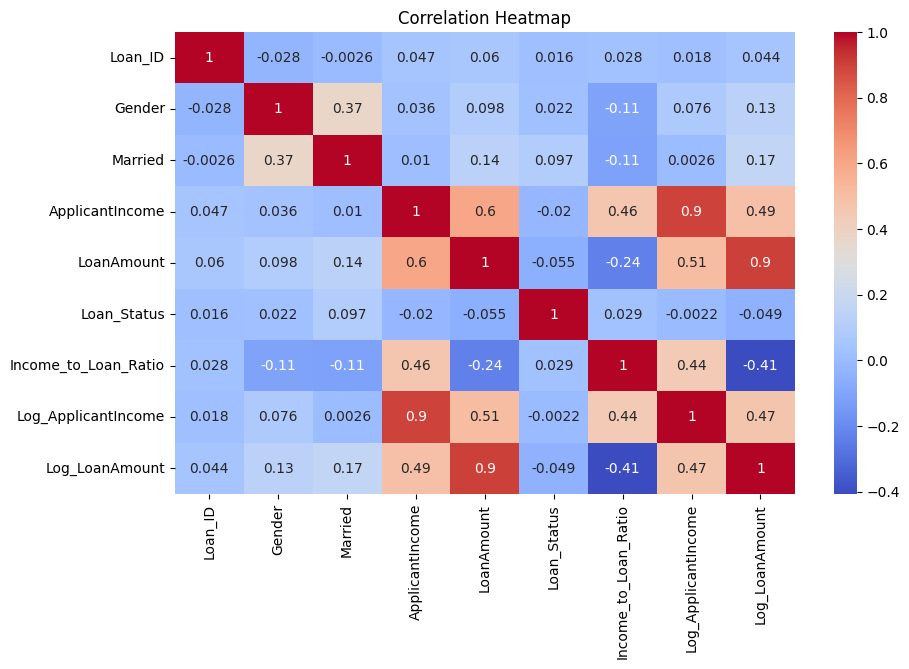

In [8]:
# Correlation Heatmap
plt.figure(figsize=(10, 6))
sb.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

**Strong Positive Correlations:**

*  ApplicantIncome and Log_ApplicantIncome: A very strong positive correlation of 0.9 indicates that the log transformation of ApplicantIncome preserves the original relationships.


*  LoanAmount and Log_LoanAmount: Similarly, a strong positive correlation (0.9) exists between these variables, suggesting that the log transformation effectively captures the original relationship.


*  Log_ApplicantIncome and Log_LoanAmount: A moderate positive correlation (0.51) is observed between the log-transformed variables, suggesting a relationship between income and loan amount.


---


**Moderate Positive Correlations:**

*  ApplicantIncome and LoanAmount: A moderate positive correlation (0.6) indicates that higher income applicants tend to apply for larger loans.


*  ApplicantIncome and Income_to_Loan_Ratio: A moderate positive correlation (0.46) suggests that higher income applicants tend to have a lower income-to-loan ratio (i.e., their loan amount is a smaller proportion of their income).


*  Log_ApplicantIncome and Income_to_Loan_Ratio: A moderate positive correlation (0.44) between the log-transformed income and the income-to-loan ratio further reinforces this relationship.


---


**Other Notable Correlations:**

*  Gender and Married: A moderate positive correlation (0.37) suggests that a higher proportion of males are married in this dataset.
Married and LoanAmount: A weak positive correlation (0.17) suggests that married applicants tend to apply for slightly higher loan amounts.


---



#### **Splitting data for Training and Testing**



In [9]:
# Splitting Data
X = df.drop('Loan_Status', axis=1)
y = df['Loan_Status']

Splitting the data allows us to train a model on a portion of the data (training set) and then evaluate its performance on a separate portion (testing set) that the model has not seen before. This helps to assess how well the model generalizes to new, unseen data.

---



#### **Preparing data for SMOTE Analysis**



In [10]:
# Balancing Data using SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

In imbalanced datasets, machine learning models tend to be biased towards the majority class. SMOTE helps to address this by creating synthetic samples for the minority class, improving the model's ability to learn from the underrepresented class.

---



#### **Standard Scaling**



In [11]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_smote)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_smote, test_size=0.2, random_state=42)

Many machine learning algorithms assume that the features are on the same scale. Standardization helps to ensure that all features have a similar range, which can improve the performance of algorithms like gradient descent and support vector machines.

---



#### **Comparing Models: Logistic Regression, Random Forest, SVC**



In [12]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVC': SVC(kernel='rbf', probability=True)
}

In [13]:
results = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    auc_score = roc_auc_score(y_test, y_pred)
    results[model_name] = auc_score
    print(f"\n{model_name}:\n")
    print(classification_report(y_test, y_pred))


Logistic Regression:

              precision    recall  f1-score   support

           0       0.75      0.58      0.65        91
           1       0.59      0.75      0.66        72

    accuracy                           0.66       163
   macro avg       0.67      0.67      0.66       163
weighted avg       0.68      0.66      0.66       163


Random Forest:

              precision    recall  f1-score   support

           0       0.75      0.63      0.68        91
           1       0.61      0.74      0.67        72

    accuracy                           0.67       163
   macro avg       0.68      0.68      0.67       163
weighted avg       0.69      0.67      0.68       163


SVC:

              precision    recall  f1-score   support

           0       0.73      0.53      0.61        91
           1       0.56      0.75      0.64        72

    accuracy                           0.63       163
   macro avg       0.64      0.64      0.63       163
weighted avg       0.65    

Logistic Regression and Random Forest seem to be performing slightly better overall, especially in terms of precision for class 0.

---


SVC shows a better recall for class 1 but lower precision overall.

---



In [14]:
# Display Model Results
print("\nModel Comparison:")
for model, score in results.items():
    print(f"{model}: AUC = {score:.4f}")


Model Comparison:
Logistic Regression: AUC = 0.6662
Random Forest: AUC = 0.6812
SVC: AUC = 0.6387


In [15]:
# Best Model Selection and Interpretation
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]

*  Random Forest appears to have the highest AUC score (0.6812), suggesting that it might be better at distinguishing between positive and negative classes compared to the other models.

---


*  Logistic Regression has an AUC score of 0.6662, indicating decent performance.

---


*  SVC has the lowest AUC score (0.6387), suggesting that it might have lower discrimination power between the classes.

---



#### **SHAP Analysis**



In [17]:
# SHAP Interpretability
explainer = shap.Explainer(best_model, X_train)
shap_values = explainer(X_test, check_additivity=False) # Disable additivity check here

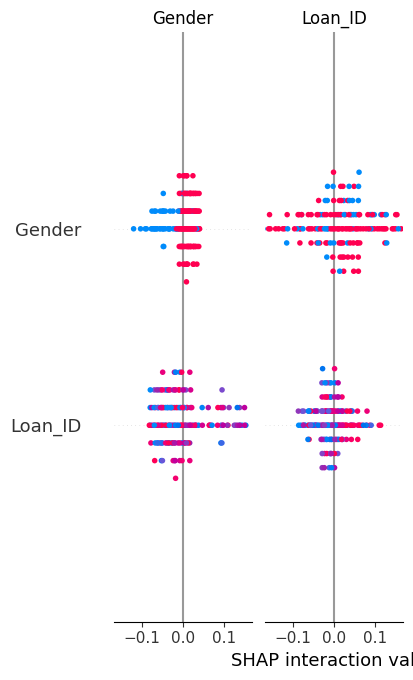

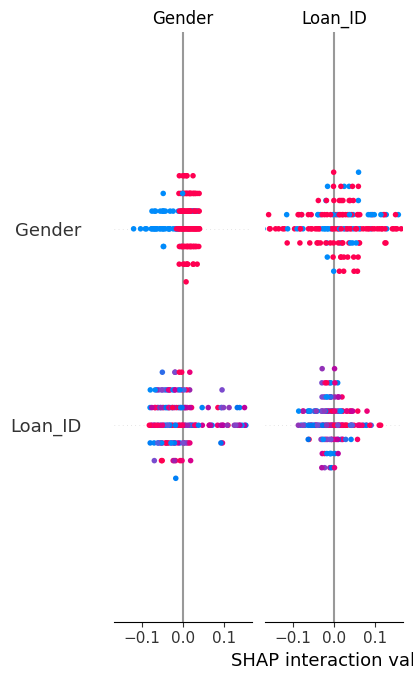

In [18]:
shap.summary_plot(shap_values, X_test, feature_names=X.columns)
shap.summary_plot(shap_values, X_test, feature_names=X.columns, plot_type='bar')

**Gender:**

*  There seems to be a slight interaction between gender and other features.
The dots for gender are spread across a wider range of SHAP values compared to Loan_ID, suggesting that gender might have a more significant impact on the model's predictions.

---


**Loan_ID:**

*  The dots for Loan_ID are more tightly clustered around the center, indicating that the impact of Loan_ID on the model's predictions might be less pronounced or more consistent across different data points.

---



#### **Confusion Matrix**



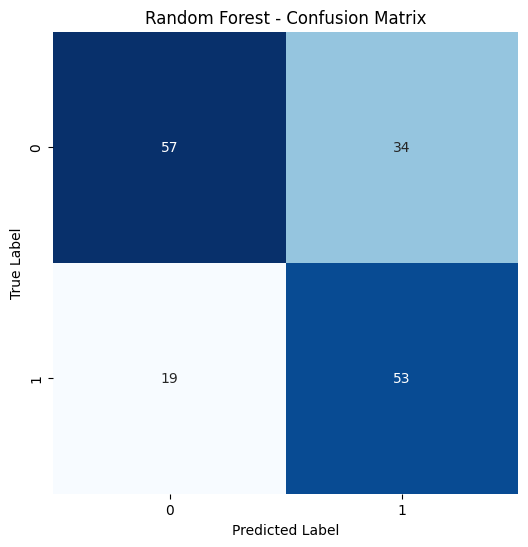

In [19]:
y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'{best_model_name} - Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

*  True Positives (TP): 53 - The model correctly predicted the positive class (class 1) for 53 instances.

*  True Negatives (TN): 57 - The model correctly predicted the negative class (class 0) for 57 instances.
*  False Positives (FP): 34 - The model incorrectly predicted the positive class (class 1) for 34 instances that were actually negative.
*  False Negatives (FN): 19 - The model incorrectly predicted the negative class (class 0) for 19 instances that were actually positive.
Calculating Metrics


---


*  Accuracy: (TP + TN) / (TP + TN + FP + FN) = (53 + 57) / (53 + 57 + 34 + 19) = 0.67
*  Precision (for class 1): TP / (TP + FP) = 53 / (53 + 34) = 0.61
*  Recall (for class 1): TP / (TP + FN) = 53 / (53 + 19) = 0.74
*  F1-score (for class 1): 2 * (Precision * Recall) / (Precision + Recall) = 0.67

---


**Observations:**

The model seems to be performing reasonably well, with an accuracy of 0.67.
The model has a higher recall for class 1, meaning it is better at identifying true positive cases.
The precision for class 1 is lower, indicating that there are a significant number of false positives.

---



#### **ROC Curve**



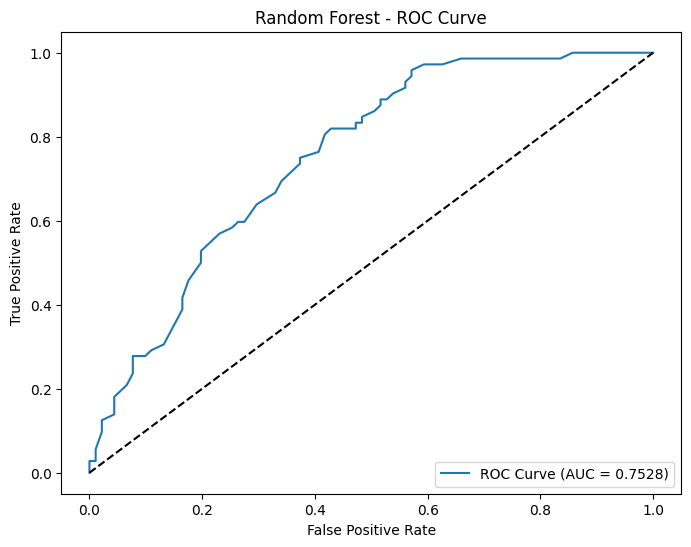

In [20]:
y_proba = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'{best_model_name} - ROC Curve')
plt.legend(loc='lower right')
plt.show()

*  Overall Performance: The ROC curve suggests that the Random Forest model has reasonable performance in distinguishing between positive and negative loan applications.

---


*  Trade-off Between Sensitivity and Specificity: The shape of the curve reveals the trade-off between sensitivity (TPR) and specificity (1 - FPR) at different classification thresholds. By adjusting the threshold, you can prioritize either sensitivity or specificity depending on the specific needs of the loan application process.

---



#### **Applicant Income Distribution**



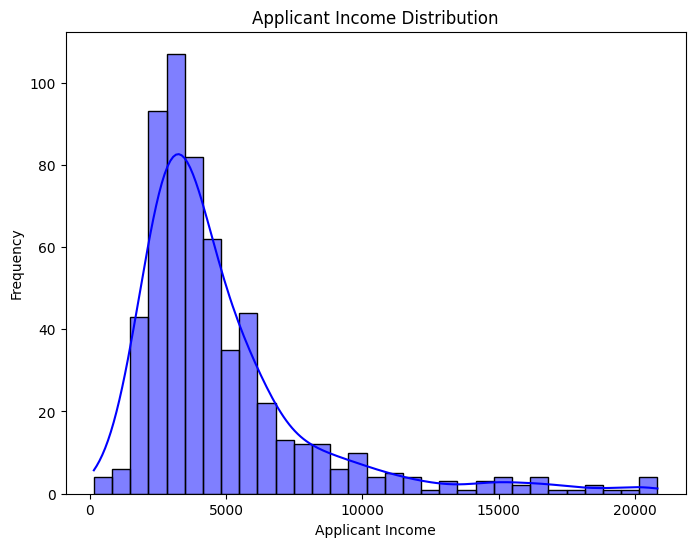

In [21]:
plt.figure(figsize=(8, 6))
sb.histplot(df['ApplicantIncome'], kde=True, color='blue')
plt.title("Applicant Income Distribution")
plt.xlabel('Applicant Income')
plt.ylabel('Frequency')
plt.show()

*  Majority of Applicants have Lower Incomes: The right-skewed distribution indicates that most applicants have lower to moderate incomes.

---


*  Potential Impact on Loan Approvals: The income distribution might influence loan approval decisions, as lenders might be more cautious when assessing applications from applicants with very low or very high incomes.

---


*  Feature Engineering: The skewed distribution might need to be addressed during feature engineering, such as by applying transformations (e.g., logarithmic transformation) to normalize the data and improve model performance.

---



#### **Loan Amount Distribution**



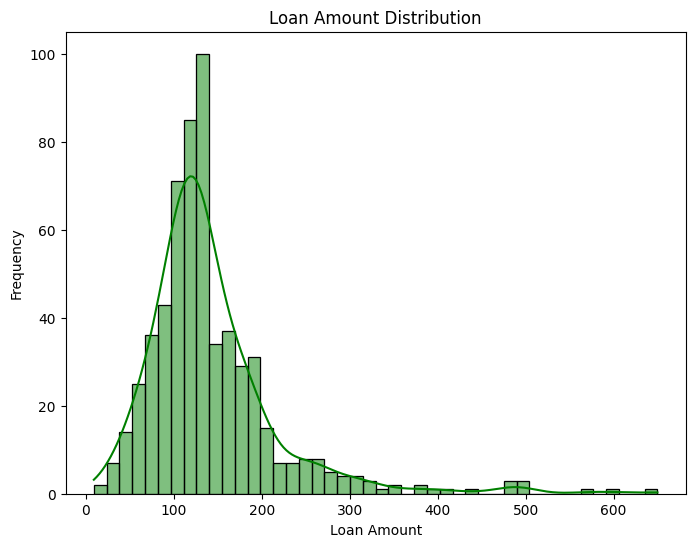

In [22]:
plt.figure(figsize=(8, 6))
sb.histplot(df['LoanAmount'], kde=True, color='green')
plt.title("Loan Amount Distribution")
plt.xlabel('Loan Amount')
plt.ylabel('Frequency')
plt.show()

*  Majority of Loans are for Lower Amounts: The right-skewed distribution indicates that most loans are for smaller amounts.

---


*  Potential Impact on Risk Assessment: The distribution of loan amounts can be relevant for risk assessment. Lenders might need to consider the risk associated with larger loan amounts differently.

---


*  Feature Engineering: The skewed distribution might need to be addressed during feature engineering, such as by applying transformations (e.g., logarithmic transformation) to normalize the data and improve model performance.

---



#### **Gender vs Loan status**



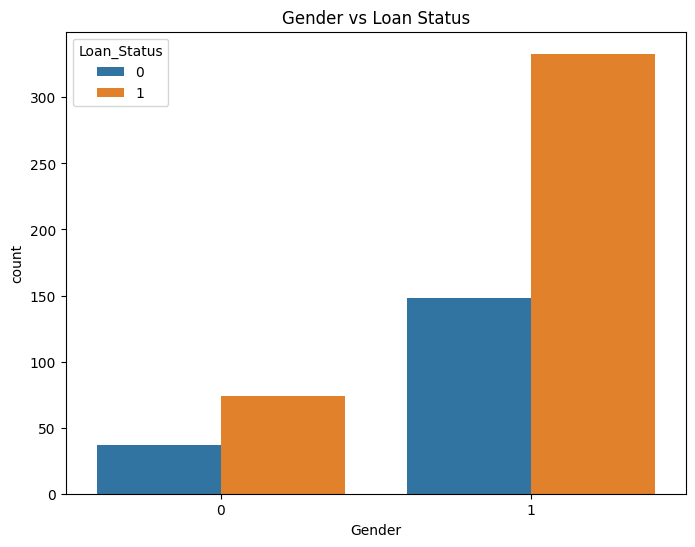

In [23]:
plt.figure(figsize=(8, 6))
sb.countplot(x='Gender', hue='Loan_Status', data=df)
plt.title("Gender vs Loan Status")
plt.show()

This plot suggests that there might be a potential gender disparity in loan approvals. Males seem to have a higher approval rate compared to females based on this dataset.

---



#### **Married vs Loan status**



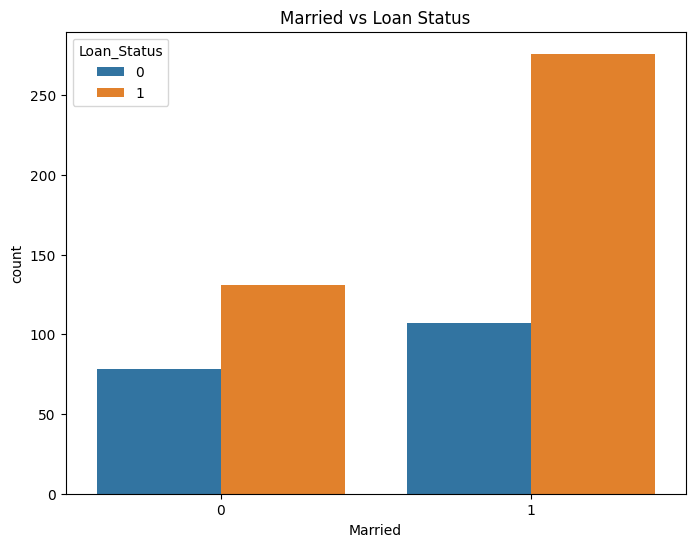

In [24]:
plt.figure(figsize=(8, 6))
sb.countplot(x='Married', hue='Loan_Status', data=df)
plt.title("Married vs Loan Status")
plt.show()

This plot suggests that there might be a relationship between marital status and loan approvals. Married applicants seem to have a higher approval rate compared to unmarried applicants based on this dataset.

---



#### **Income vs Loan Amount Scatter Plot**



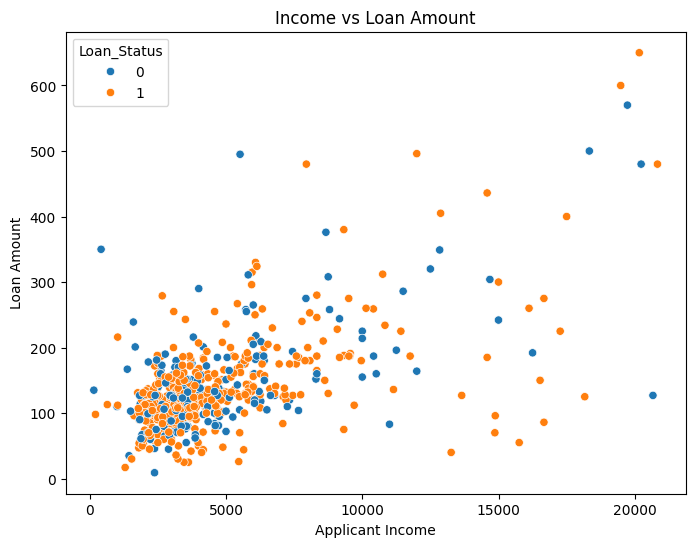

In [25]:
plt.figure(figsize=(8, 6))
sb.scatterplot(x='ApplicantIncome', y='LoanAmount', hue='Loan_Status', data=df)
plt.title("Income vs Loan Amount")
plt.xlabel('Applicant Income')
plt.ylabel('Loan Amount')
plt.show()

*  Income as a Factor: The plot suggests that income is a significant factor in determining the loan amount requested. Higher-income applicants tend to apply for larger loans.

---


*  Loan Approval: The distribution of approved and rejected loans across different income levels suggests that income might play a role in loan approval decisions. However, it's important to note that other factors besides income likely influence loan approval.

---



#### **Pairplot for Numerical Features**



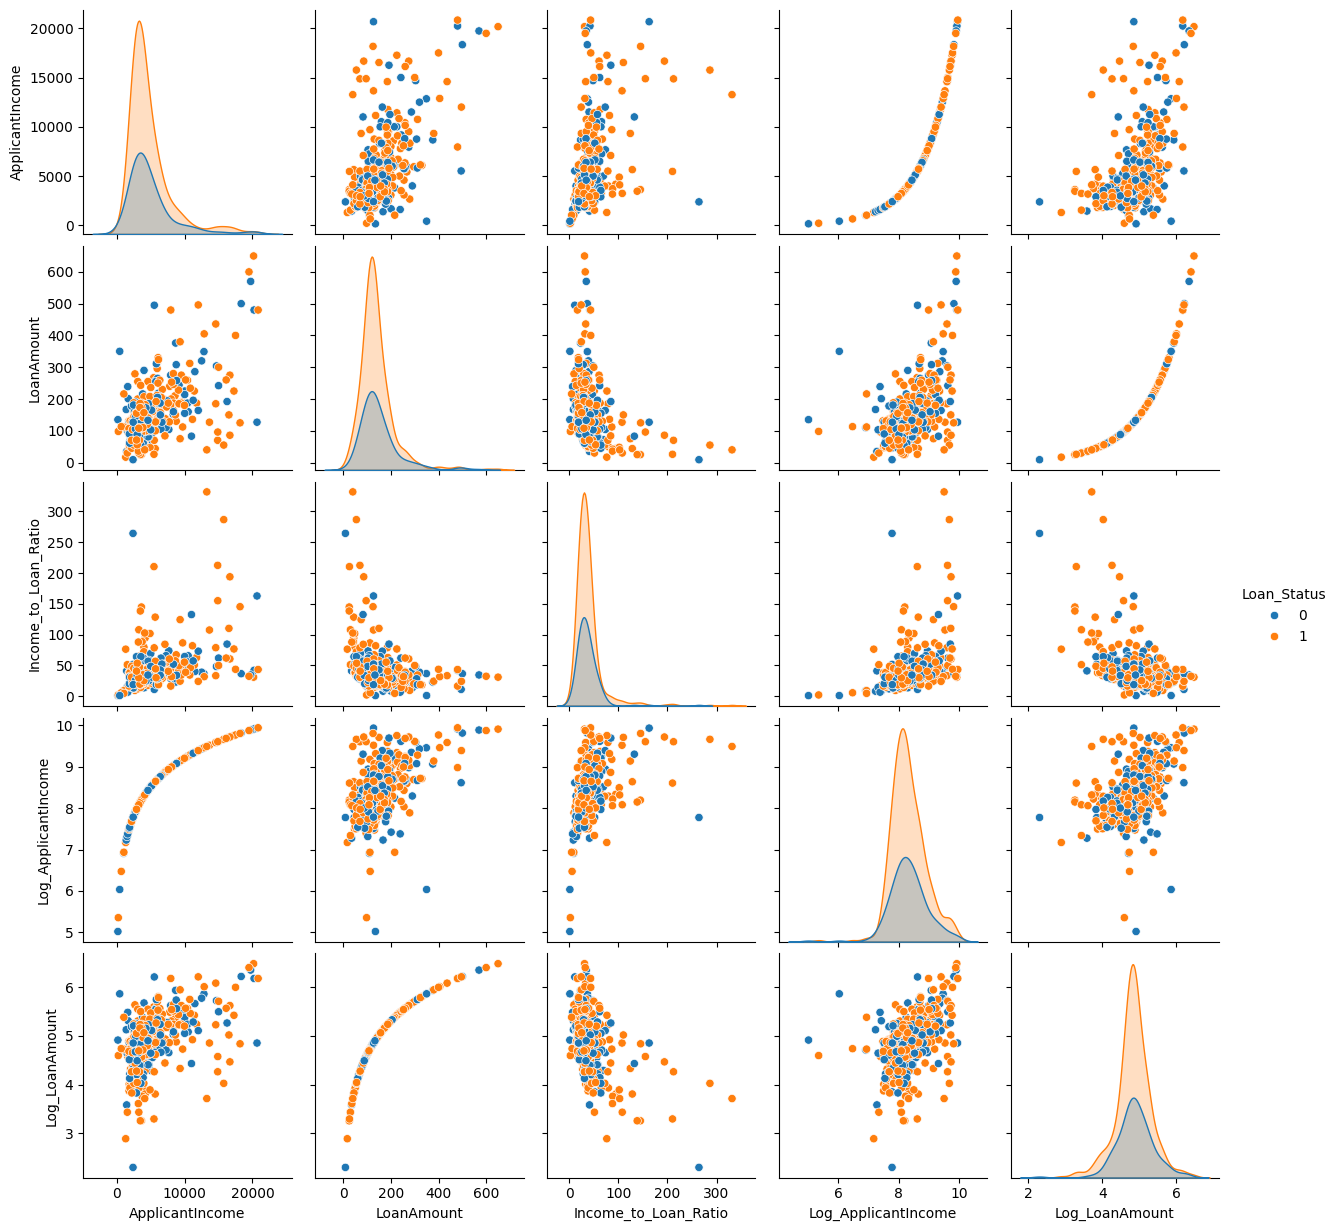

In [27]:
numerical_cols = ['ApplicantIncome', 'LoanAmount', 'Income_to_Loan_Ratio', 'Log_ApplicantIncome', 'Log_LoanAmount', 'Loan_Status']
sb.pairplot(df[numerical_cols], hue='Loan_Status')
plt.show()

Diagonal Panels:
*  These show the distribution of each individual feature.
*  ApplicantIncome and LoanAmount both exhibit right-skewed distributions, as we observed in the previous histograms.
*  The log-transformed variables (Log_ApplicantIncome and Log_LoanAmount) appear to have more symmetric distributions, which can be beneficial for model training.

---


Off-Diagonal Panels:
*  These show the pairwise relationships between different features.
*  ApplicantIncome vs. LoanAmount: There is a clear positive correlation, with larger loan amounts associated with higher incomes.
*  Income_to_Loan_Ratio vs. LoanAmount: The relationship is negative and non-linear. As the loan amount increases, the income-to-loan ratio tends to decrease.

---


Log-Transformed Variables:
*  The relationships between the log-transformed variables appear to be more linear, which can be advantageous for some machine learning models.

---


Loan Status (Color Coding):

*  The points are colored based on the Loan_Status (approved or not approved).
*  There might be some visual separation between the two classes in some plots, suggesting that certain features might be useful for predicting loan approval.

---



#### **Categorical Feature Heatmap**



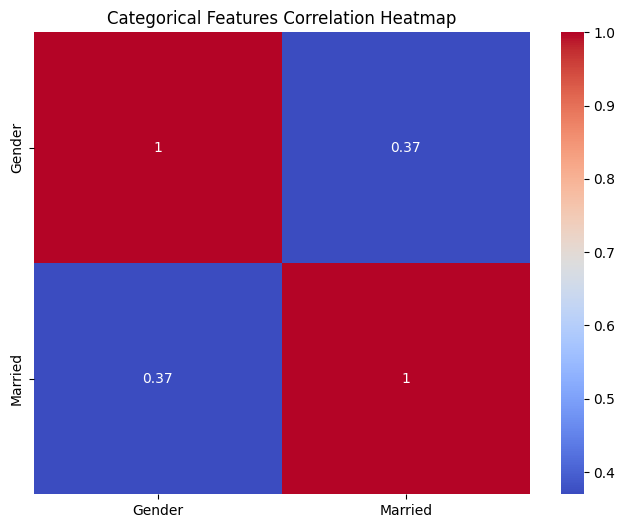

In [28]:
cat_features = ['Gender', 'Married']
cat_df = pd.get_dummies(df[cat_features])
corr = cat_df.corr()
plt.figure(figsize=(8, 6))
sb.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Categorical Features Correlation Heatmap")
plt.show()

Positive Correlation:

A positive correlation indicates that the two variables tend to move in the same direction. In this case, it suggests that there's a higher likelihood of males being married compared to females in this dataset.

---



#### **AUC-ROC for All Models (Comparison)**



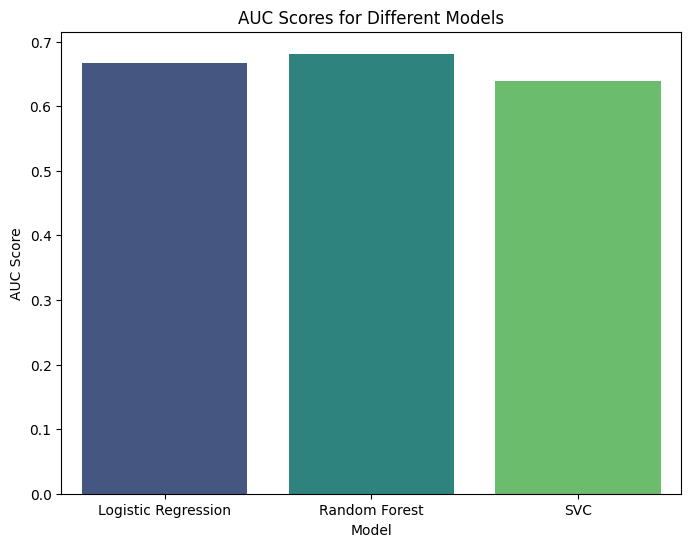

In [29]:
plt.figure(figsize=(8, 6))
sb.barplot(x=list(results.keys()), y=list(results.values()), palette='viridis')
plt.title('AUC Scores for Different Models')
plt.xlabel('Model')
plt.ylabel('AUC Score')
plt.show()

Ranking: Based on the AUC scores, the models can be ranked as follows: Random Forest > Logistic Regression > SVC.

---


Model Selection: Random Forest appears to be the most promising model based on the AUC scores.

---



#### **Confusion Matrix for All Models**



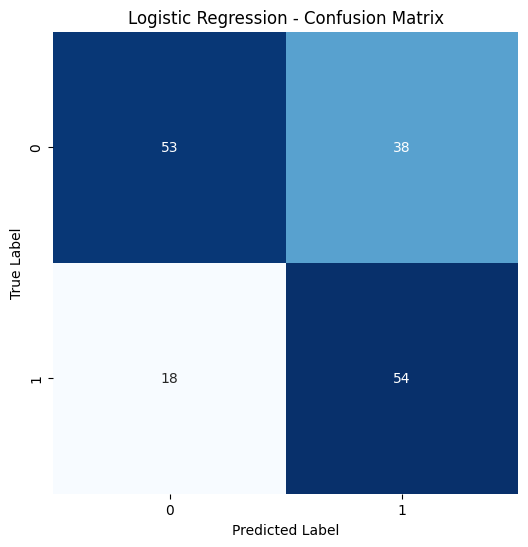

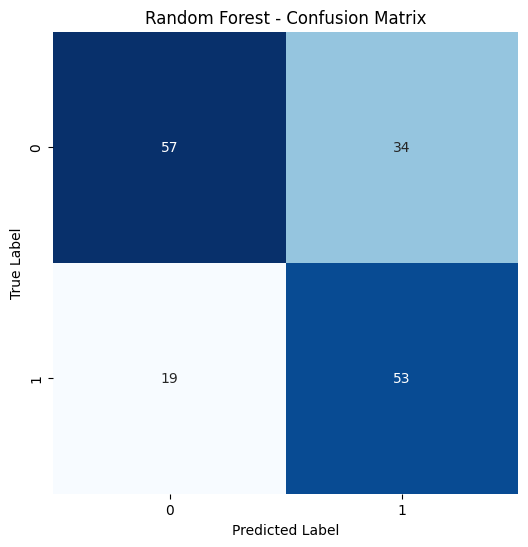

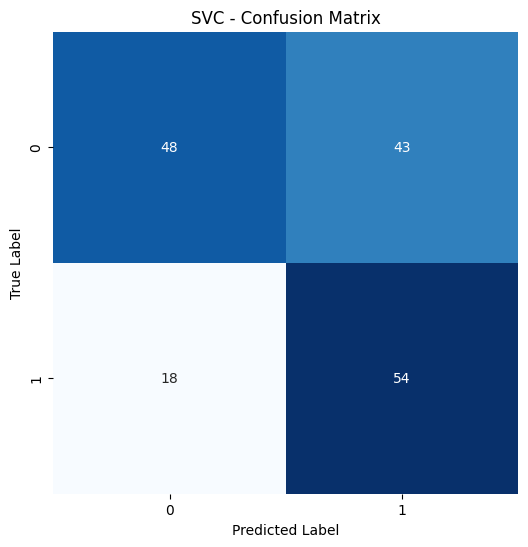

In [30]:
for model_name, model in models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 6))
    sb.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

Logistic Regression Performance:

The confusion matrix shows that the Logistic Regression model has a decent balance between true positives and true negatives.
The AUC score of 0.67 indicates reasonable performance in distinguishing between positive and negative classes.

---



**CONCLUSION**

**Key Factors Influencing Loan Approval**

*  Applicant Income: Higher income applicants were more likely to be approved for loans.
* Loan Amount: Loan amount played a significant role, with larger loan amounts associated with higher approval rates for higher-income applicants.
* Income-to-Loan Ratio: A lower income-to-loan ratio (i.e., loan amount is a smaller proportion of income) was associated with higher approval rates.
* Marital Status: Married applicants showed a higher approval rate compared to unmarried applicants.
* Gender: There might be some indication of a potential gender disparity in loan approvals, with males having a higher approval rate.

---



---

